In [ ]:
import tensorflow as tf
#plot tools
import seaborn as sns
import matplotlib.pyplot as plt
#simple tools
import numpy as np
import pandas as pd
from sklearn.utils import resample

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define dataset path
train_dataset_path = '/content/drive/MyDrive/skripsi/datasetfix.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Membaca dataset
train_data = pd.read_csv(train_dataset_path, delimiter=';', encoding='latin-1')

# Menampilkan 5 baris pertama dari data
train_data.head()

,text,label
0,Mobil. Mobil sudah ada sejak menjadi terkenal ...,0
1,Transportasi merupakan kebutuhan utama di seba...,0
2,"""Hubungan cinta Amerika dengan kendaraannya ta...",0
3,Seberapa sering Anda naik mobil? Apakah Anda m...,0
4,Mobil adalah hal yang luar biasa. Mobil mungki...,0


In [ ]:
train_data.shape

(10143, 2)

In [ ]:
# Mengecek jumlah nilai NaN di setiap kolom
print("Jumlah nilai NaN di setiap kolom:")
print(train_data.isna().sum())

# Menampilkan baris yang mengandung nilai NaN
print("\nBaris yang mengandung nilai NaN:")
print(train_data[train_data.isna().any(axis=1)])

Jumlah nilai NaN di setiap kolom:
text     2
label    0
dtype: int64

Baris yang mengandung nilai NaN:
     text  label
5624  NaN      1
5625  NaN      1


In [ ]:
# Pastikan tidak ada nilai NaN di kolom 'label' dan konversi tipe data ke integer
train_data['label'] = train_data['label'].fillna(0).astype(int)

# Menampilkan distribusi label setelah memastikan kolom bersih dari NaN atau nilai negatif
if (train_data['label'] < 0).any():
    print("Kolom 'label' memiliki nilai negatif, harap periksa data Anda.")
else:
    print("\nDistribusi label pada kolom 'label':")
    print(np.bincount(train_data['label']))


Distribusi label pada kolom 'label':
[5005 5138]


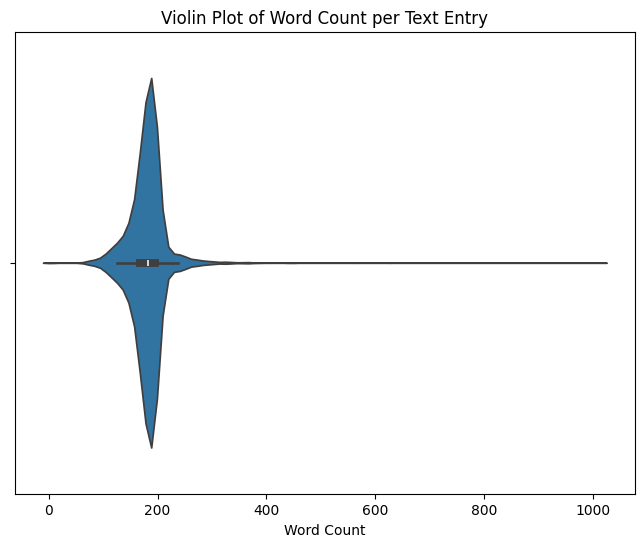

In [ ]:
# Menghitung jumlah kata per baris di kolom 'text'
train_data['word_count'] = train_data['text'].apply(lambda x: len(str(x).split()))

# Membuat plot violin untuk jumlah kata per baris
plt.figure(figsize=(8, 6))
sns.violinplot(x=train_data['word_count'])
plt.title('Violin Plot of Word Count per Text Entry')
plt.xlabel('Word Count')
plt.show()

In [ ]:
# Memisahkan data berdasarkan kelas mayoritas dan minoritas
majority_class = train_data[train_data['label'] == 1]
minority_class = train_data[train_data['label'] == 0]

In [ ]:
# Downsample kelas mayoritas agar seimbang dengan kelas minoritas
majority_downsampled = resample(majority_class,
                                replace=False,  # Sampling tanpa penggantian
                                n_samples=len(minority_class),  # Menyamakan jumlah dengan kelas minoritas
                                random_state=42)  # Untuk reproduktifitas

In [ ]:
# Menggabungkan kembali kelas mayoritas yang di-downsample dengan kelas minoritas
train_data_balanced = pd.concat([majority_downsampled, minority_class])

In [ ]:
# Menampilkan distribusi label setelah penyeimbangan
print("\nDistribusi label setelah penyeimbangan:")
print(np.bincount(train_data_balanced['label']))


Distribusi label setelah penyeimbangan:
[5005 5005]


#Pre Processing Data

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# 1. Data Cleaning (menghapus URL, tanda baca, angka, dll.)
def clean_text(text):
    if isinstance(text, str):  # Pastikan hanya teks yang diolah
        original_text = text
        # Mengubah teks menjadi huruf kecil
        text = text.lower()
        # Menghapus URL
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        # Menghapus tanda baca dan karakter khusus
        text = re.sub(r'\W', ' ', text)
        # Menghapus angka
        text = re.sub(r'\d', '', text)
        # Menghapus spasi berlebih
        text = re.sub(r'\s+', ' ', text).strip()
        return original_text, text
    else:
        return text, text  # Kembalikan teks asli jika bukan string

# Terapkan pembersihan teks dan tampilkan sebelum dan sesudah pembersihan
train_data_balanced[['original_text', 'cleaned_text']] = train_data_balanced['text'].apply(lambda x: pd.Series(clean_text(x)))

print("\nData sebelum dan sesudah cleaning:")
print(train_data_balanced[['original_text', 'cleaned_text']].head())



Data sebelum dan sesudah cleaning:
                                          original_text  \
5843  Anjing telah lama menjadi teman yang disayangi...   
5982  Pernahkah Anda merasa kewalahan dengan banyakn...   
8990  Generic_Name dihadapkan pada tugas berat untuk...   
5803  Senator Negara Bagian yang terhormat,\nSaya me...   
7047  Media sosial telah menjadi bagian tak terpisah...   

                                           cleaned_text  
5843  anjing telah lama menjadi teman yang disayangi...  
5982  pernahkah anda merasa kewalahan dengan banyakn...  
8990  generic_name dihadapkan pada tugas berat untuk...  
5803  senator negara bagian yang terhormat saya menu...  
7047  media sosial telah menjadi bagian tak terpisah...  


In [ ]:
# 1. Pastikan semua nilai di kolom 'cleaned_text' adalah string
train_data_balanced['cleaned_text'] = train_data_balanced['cleaned_text'].fillna("").astype(str)

# 2. Modifikasi fungsi untuk menghapus stopwords
stop_words = set(stopwords.words('indonesian'))  # Ganti 'indonesian' dengan bahasa yang sesuai

def remove_stopwords(text):
    if isinstance(text, str):  # Pastikan nilai yang diolah adalah string
        words = word_tokenize(text)
        filtered_text = [word for word in words if word not in stop_words]
        return ' '.join(filtered_text)
    else:
        return ""  # Kembalikan string kosong jika bukan string

# Terapkan penghapusan stopwords dan tampilkan hasilnya
train_data_balanced['text_without_stopwords'] = train_data_balanced['cleaned_text'].apply(remove_stopwords)

print("\nData setelah stopwords dihapus:")
print(train_data_balanced[['cleaned_text', 'text_without_stopwords']].head())


Data setelah stopwords dihapus:
                                           cleaned_text  \
5843  anjing telah lama menjadi teman yang disayangi...   
5982  pernahkah anda merasa kewalahan dengan banyakn...   
8990  generic_name dihadapkan pada tugas berat untuk...   
5803  senator negara bagian yang terhormat saya menu...   
7047  media sosial telah menjadi bagian tak terpisah...   

                                 text_without_stopwords  
5843  anjing teman disayangi manusia cinta dukungan ...  
5982  pernahkah kewalahan banyaknya keputusan hidup ...  
8990  generic_name dihadapkan tugas berat keputusan ...  
5803  senator negara terhormat menulis pendapat topi...  
7047  media sosial terpisahkan kehidupan sehari oran...  


In [ ]:
# 3. Tokenizing
train_data_balanced['tokenized_text'] = train_data_balanced['text_without_stopwords'].apply(word_tokenize)

print("\nData setelah tokenisasi:")
print(train_data_balanced[['text_without_stopwords', 'tokenized_text']].head())


Data setelah tokenisasi:
                                 text_without_stopwords  \
5843  anjing teman disayangi manusia cinta dukungan ...   
5982  pernahkah kewalahan banyaknya keputusan hidup ...   
8990  generic_name dihadapkan tugas berat keputusan ...   
5803  senator negara terhormat menulis pendapat topi...   
7047  media sosial terpisahkan kehidupan sehari oran...   

                                         tokenized_text  
5843  [anjing, teman, disayangi, manusia, cinta, duk...  
5982  [pernahkah, kewalahan, banyaknya, keputusan, h...  
8990  [generic_name, dihadapkan, tugas, berat, keput...  
5803  [senator, negara, terhormat, menulis, pendapat...  
7047  [media, sosial, terpisahkan, kehidupan, sehari...  


#Splitting Data

In [ ]:
from sklearn.model_selection import train_test_split

# Split dataset into training + validation, and test set
train_val_data, test_data = train_test_split(train_data_balanced, test_size=0.1, random_state=42, stratify=train_data_balanced['label'])

# Split training + validation set further into training and validation sets
train_data, val_data = train_test_split(train_val_data, test_size=0.1, random_state=42, stratify=train_val_data['label'])

# Print sizes of each split to verify
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")


Training set size: 8108
Validation set size: 901
Test set size: 1001


In [ ]:
train_data.shape

(8108, 7)

In [ ]:
from gensim.models import Word2Vec

# Definisi ukuran embedding
embedding_dimensions = 150

# Membuat dataset untuk Word2Vec dengan tokenisasi teks pada data pelatihan
word2vec_train_data = list(map(lambda x: x.split(), train_data['cleaned_text']))

# Melatih model Word2Vec
word2vec_model = Word2Vec(
    sentences=word2vec_train_data,       # Data latih yang sudah di-tokenisasi
    vector_size=embedding_dimensions,    # Ukuran vektor embedding
    window=5,                            # Jarak maksimum antara kata saat pelatihan
    min_count=5,                         # Mengabaikan kata yang muncul kurang dari 5 kali
    workers=8,                           # Jumlah core CPU yang digunakan
    sg=0                                 # Gunakan model CBOW (sg=0), atau Skip-Gram (sg=1)
)

# Menampilkan panjang vocabulary dari model Word2Vec yang telah dilatih
print("Panjang Vocabulary:", len(word2vec_model.wv.key_to_index))


Panjang Vocabulary: 6953


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Inisialisasi tokenizer dan sesuaikan dengan data teks
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['cleaned_text'])  # Melatih tokenizer pada teks hasil preprocessing

# Panjang maksimal urutan
input_length = 200

# Konversi teks ke urutan numerik, lalu lakukan padding agar panjangnya seragam
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data['cleaned_text']), maxlen=input_length)
X_val = pad_sequences(tokenizer.texts_to_sequences(val_data['cleaned_text']), maxlen=input_length)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data['cleaned_text']), maxlen=input_length)

# Menampilkan bentuk akhir dari X_train, X_val, dan X_test
print("X_train.shape:", X_train.shape)
print("X_val.shape  :", X_val.shape)
print("X_test.shape :", X_test.shape)


X_train.shape: (8108, 200)
X_val.shape  : (901, 200)
X_test.shape : (1001, 200)


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
# Tentukan ukuran vocab dan embedding dimensions
vocab_length = len(tokenizer.word_index) + 1  # +1 karena tokenizer sudah memetakan kata ke index
Embedding_dimensions = 150

# Menyiapkan embedding matrix dari Word2Vec
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))
for word, index in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[index] = word2vec_model.wv[word]

In [ ]:
# Membuat model
def getModel():
    embedding_layer = Embedding(input_dim=vocab_length,
                                output_dim=Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)  # Membuat embedding layer non-trainable

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ], name="Sentiment_Model")
    return model


In [ ]:
# Membuat model
training_model = getModel()
training_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "Sentiment_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       2,516,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,516,550 (9.60 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,516,550 (9.60 MB)

In [ ]:
# Compile the model before training
training_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Menyiapkan callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
    EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)
]

# Memastikan X_train, y_train, X_val, y_val, X_test, y_test cocok
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data_balanced['cleaned_text']), maxlen=input_length)
X_val = pad_sequences(tokenizer.texts_to_sequences(val_data['cleaned_text']), maxlen=input_length)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data['cleaned_text']), maxlen=input_length)

# Pastikan label (y_train, y_val, y_test) diambil dari data yang benar
y_train = train_data_balanced['label'].values
y_val = val_data['label'].values
y_test = test_data['label'].values

# Periksa ukuran akhir
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (10010, 200)
y_train shape: (10010,)


In [ ]:
# Melatih model
history = training_model.fit(
    X_train, y_train,
    batch_size=256,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.8643 - loss: 0.3082 - val_accuracy: 0.9623 - val_loss: 0.1099 - learning_rate: 0.0010
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.9670 - loss: 0.0972 - val_accuracy: 0.9778 - val_loss: 0.0708 - learning_rate: 0.0010
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9770 - loss: 0.0707 - val_accuracy: 0.9856 - val_loss: 0.0552 - learning_rate: 0.0010
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9775 - loss: 0.0698 - val_accuracy: 0.9834 - val_loss: 0.0518 - learning_rate: 0.0010
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9823 - loss: 0.0518 - val_accuracy: 0.9845 - val_loss: 0.0501 - learning_rate: 0.0010
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.9828 - loss: 0.0455 - val_accuracy: 0.9878 - val_loss: 0.0358 - learning_rate: 0.0010
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9844 - loss: 0.0433 - 

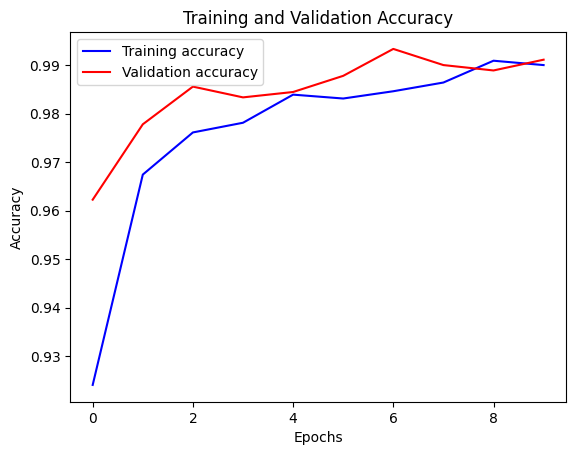

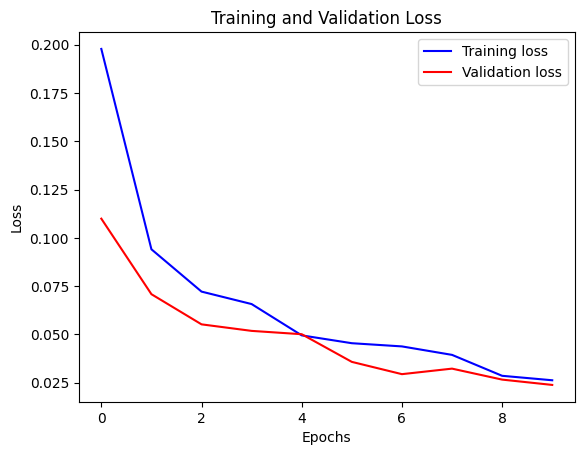

In [ ]:
import matplotlib.pyplot as plt

# Mengambil nilai akurasi dan loss untuk pelatihan dan validasi
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Menentukan jumlah epochs
epochs = range(len(acc))

# Plot Training dan Validation Accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training dan Validation Loss
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Tampilkan grafik
plt.show()


In [ ]:
print(f"Training Accuracy: {max(acc):.3f}")
print(f"Validation Accuracy: {max(val_acc):.3f}")


Training Accuracy: 0.991
Validation Accuracy: 0.993


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(y_true, y_pred):
    # Compute the confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)

    # Define label names and group names for the confusion matrix
    categories = ['AI', 'Human']
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    # Create labels for each square in the matrix
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    # Plot confusion matrix heatmap
    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='',
                xticklabels=categories, yticklabels=categories)

    plt.xlabel("Predicted Values", fontdict={'size':14}, labelpad=10)
    plt.ylabel("Actual Values", fontdict={'size':14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size':18}, pad=20)
    plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


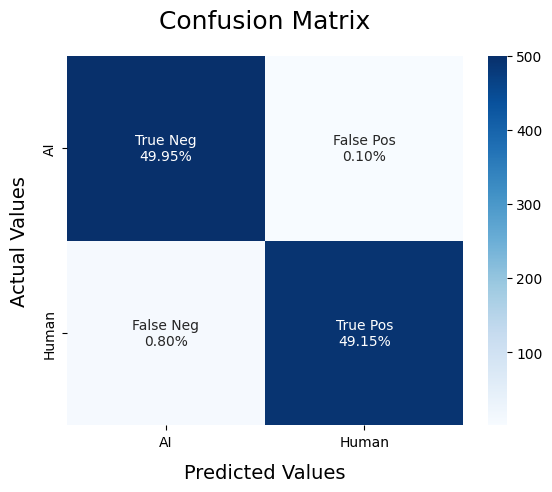

              precision    recall  f1-score   support

       Human       0.98      1.00      0.99       501
          AI       1.00      0.98      0.99       500

    accuracy                           0.99      1001
   macro avg       0.99      0.99      0.99      1001
weighted avg       0.99      0.99      0.99      1001



In [ ]:
# Get the test data and true labels
X_test = test_data['cleaned_text']  # Replace with actual text column
y_test = test_data['label']         # Replace with actual label column

# Tokenize and pad the test data
X_test_sequences = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=input_length)

# Make predictions on the test data
y_pred_proba = training_model.predict(X_test_sequences)

# Convert prediction probabilities to binary outcomes (0 or 1)
y_pred = np.where(y_pred_proba >= 0.5, 1, 0)

# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred)

# Print the classification report
print(classification_report(y_test, y_pred, target_names=['Human', 'AI']))

In [ ]:
# import pickle

# training_model.save('/content/drive/MyDrive/model_bilstmcb.h5')
# tokenizer_path = '/content/drive/MyDrive/tokenizercb.pkl'

# # Save the tokenizer using pickle
# with open(tokenizer_path, 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# from tensorflow.keras.models import load_model

# # Load model yang sudah terlatih
# model = load_model('/content/drive/MyDrive/model_bilstmm.h5')  # Sesuaikan path jika berbeda

# # Load tokenizer yang digunakan saat melatih model
# with open('/content/drive/MyDrive/tokenizer3.pkl', 'rb') as handle:  # Sesuaikan path jika berbeda
#       tokenizer = pickle.load(handle)

# # Fungsi untuk memprediksi apakah kalimat tersebut buatan AI atau manusia
# def predict_sentence(sentence):
#     # Preprocessing kalimat: tokenisasi dan padding
#     sequence = tokenizer.texts_to_sequences([sentence])
#     padded_sequence = pad_sequences(sequence, maxlen=250)    # Sesuaikan dengan maxlen saat pelatihan

#     # Prediksi
#     prediction = model.predict(padded_sequence)

#     # Interpretasi hasil
#     if prediction >= 0.3:
#         result = "Kalimat ini mungkin buatan AI."
#     else:
#         result = "Kalimat ini mungkin buatan manusia."

#     return result

# # Input kalimat dari pengguna
# sentence = input("Masukkan kalimat untuk diprediksi: ")
print(predict_sentence(sentence))